# PRE-SWOT NUMERICAL SIMULATION VERSION 1 User Guide Demo

## Copied/modified from:
## https://github.com/podaac/tutorials/blob/master/notebooks/Pre-SWOT_Numerical_Simulation_Demo.ipynb
===================================================

Author: Jinbo Wang <Jinbo.Wang@jpl.nasa.gov>, Jack McNelis <jack.mcnelis@jpl.nasa.gov>

This is a demonstration of accessing the ECCO-BASED PRE-SWOT NUMERICAL SIMULATION. The dataset can be found following https://search.earthdata.nasa.gov/search?q=pocloud%20pre-swot.


In [1]:
import s3fs
import requests
import xarray as xr
import pylab as plt
from netrc import netrc
from urllib import request
from platform import system
from getpass import getpass
from http.cookiejar import CookieJar
from os.path import expanduser, join

ShortName = "MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0"
target_file = "LLC4320_pre-SWOT_ACC_SMST_20111221.nc"

**Earthdata Login**

Authenticate with your Earthdata Login/URS credentials by configuring a *.netrc* file in your home directory.

```
machine urs.earthdata.nasa.gov username myusername password mypassword
```

>*Note this next cell first tries to establish in-region acccess to the netCDF file in S3. (It assumes that you are running the notebook inside AWS EC2 in the `aws-west-2` region.) Upon failure, it assumes that you are running from your local machine, and so it tries to download and open the file the normal way.*

Run the next cell to authenticate. (You might be prompted for your Earthdata Login username and password.)

In [6]:
def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
setup_earthdata_login_auth()

Tom note: I had some trouble with the above cell.  I had to manually edit my netrc file.  One could just make a new netrc file.  On windows, it should be named "\_netrc" and on Mac/linux, ".netrc", and it should be in your home directory.  It should contain the following:
```text
machine urs.earthdata.nasa.gov
login <USERNAME>
password <PASSWORD>
```

You should now be able to download the file at the following link:

In [7]:
https_access = f"https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/{ShortName}/{target_file}"

print(https_access)

https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0/LLC4320_pre-SWOT_ACC_SMST_20111221.nc


**Open the dataset**

Run the next cell to access/open the netCDF file with *xarray*:

In [8]:
def begin_s3_direct_access():
    """Returns s3fs object for accessing datasets stored in S3."""
    response = requests.get("https://archive.podaac.earthdata.nasa.gov/s3credentials").json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'], 
                             client_kwargs={'region_name':'us-west-2'})

try:
    fs = begin_s3_direct_access()
    # Load netCDF with 's3fs' and 'xarray' upon successful connection to S3:
    dd = xr.open_dataset(fs.open(f"podaac-ops-cumulus-protected/{ShortName}/{target_file}"))
except:
    print("Failed to establish AWS in-region access. Downloading to local disk instead.")
    request.urlretrieve(https_access, target_file)
    # Load netCDF with 'xarray' after download completes:
    
    dd = xr.open_dataset(target_file)

print(dd)

Failed to establish AWS in-region access. Downloading to local disk instead.
<xarray.Dataset>
Dimensions:   (i: 192, i_g: 192, j: 349, j_g: 349, k: 84, k_l: 84, k_p1: 85, k_u: 84, nb: 2, time: 24)
Coordinates:
  * j_g       (j_g) float32 0.0 1.0 2.0 3.0 4.0 ... 345.0 346.0 347.0 348.0
  * i         (i) float32 0.0 1.0 2.0 3.0 4.0 ... 187.0 188.0 189.0 190.0 191.0
  * i_g       (i_g) float32 0.0 1.0 2.0 3.0 4.0 ... 188.0 189.0 190.0 191.0
  * j         (j) float32 0.0 1.0 2.0 3.0 4.0 ... 344.0 345.0 346.0 347.0 348.0
  * k         (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 74 75 76 77 78 79 80 81 82 83
  * k_u       (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82 83
  * k_l       (k_l) int32 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82 83
  * k_p1      (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 75 76 77 78 79 80 81 82 83 84
  * nb        (nb) int32 0 1
  * time      (time) datetime64[ns] 2011-12-21 ... 2011-12-21T23:00:00
Data variables:
    XC        (j, i) float32 ...
    YC 

Plot eight 2D fields.
-------------------

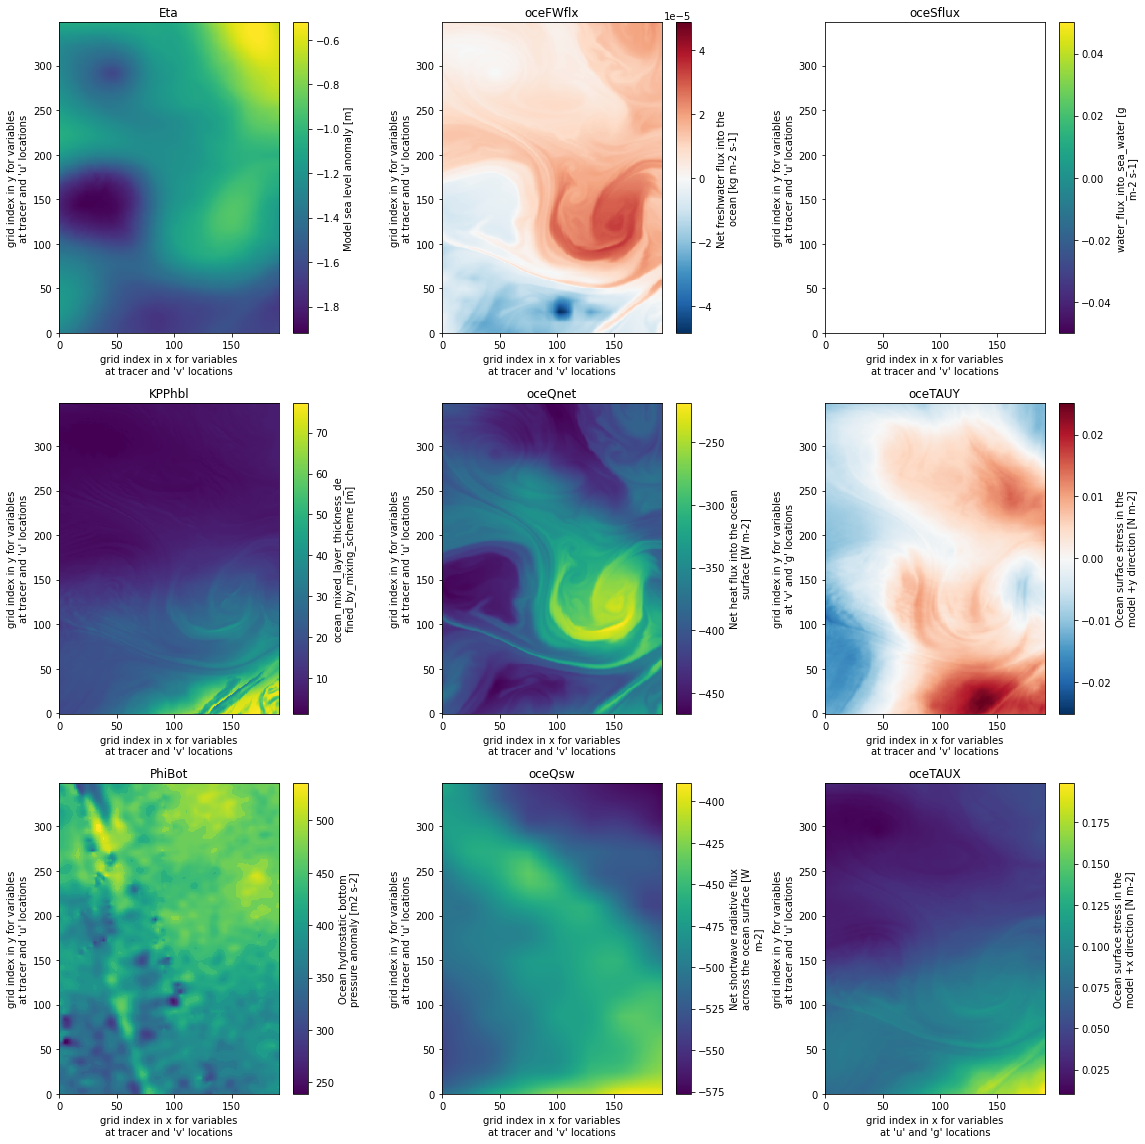

In [9]:
fig,ax=plt.subplots(3,3,figsize=(16,16))

varn=['Eta','KPPhbl','PhiBot','oceFWflx','oceQnet','oceQsw','oceSflux','oceTAUY','oceTAUX']

for i in range(3):
    for j in range(3):
        dd[varn[i*3+j]][0,...].plot(ax=ax[j,i])
        ax[j,i].set_title(varn[i*3+j])
plt.tight_layout()

Plot a 3D field based (temperature)
---------------------------------

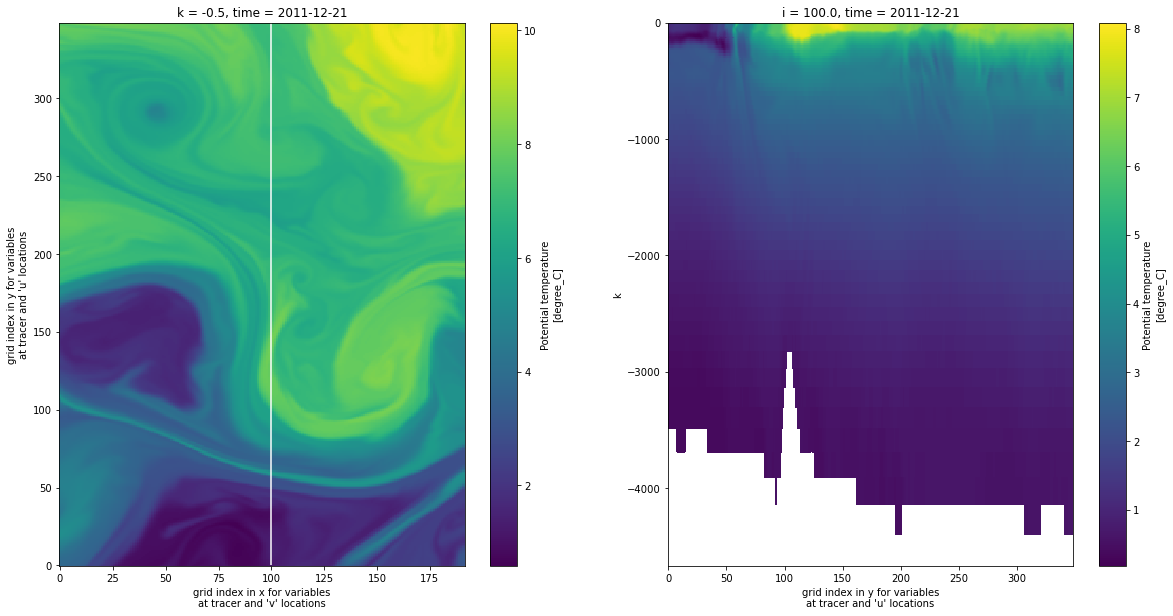

In [7]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
theta=dd['Theta'][:]
theta.coords['k']=dd['Z'].data

theta[0,0,...].plot(ax=ax[0])
ax[0].vlines(100,0,400,colors='w')
theta[0,:,:,100].plot(ax=ax[1])